In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
from pathlib import Path
from torch import nn
from torchinfo import summary
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

In [2]:
# from data_transformation import image_transform
import helper_functions
import mlflow

In [26]:
import torchvision.transforms as transforms
image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0], std=[1])
])

In [28]:
train_data = ImageFolder("chest_xray/train", transform = image_transform)
test_data = ImageFolder("chest_xray/test", transform = image_transform)
validation_data = ImageFolder("chest_xray/val", transform = image_transform)
image, label = train_data[0]
print(image.shape, label)
print(image)

torch.Size([3, 224, 224]) 0
tensor([[[0.0863, 0.0784, 0.0745,  ..., 0.3725, 0.3725, 0.3725],
         [0.0863, 0.0824, 0.0745,  ..., 0.3647, 0.3725, 0.3725],
         [0.0902, 0.0824, 0.0745,  ..., 0.3647, 0.3686, 0.3647],
         ...,
         [0.1176, 0.1137, 0.1098,  ..., 0.2353, 0.2353, 0.2353],
         [0.1373, 0.1373, 0.1333,  ..., 0.3176, 0.3216, 0.3216],
         [0.1765, 0.1765, 0.1765,  ..., 0.4196, 0.4235, 0.4235]],

        [[0.0863, 0.0784, 0.0745,  ..., 0.3725, 0.3725, 0.3725],
         [0.0863, 0.0824, 0.0745,  ..., 0.3647, 0.3725, 0.3725],
         [0.0902, 0.0824, 0.0745,  ..., 0.3647, 0.3686, 0.3647],
         ...,
         [0.1176, 0.1137, 0.1098,  ..., 0.2353, 0.2353, 0.2353],
         [0.1373, 0.1373, 0.1333,  ..., 0.3176, 0.3216, 0.3216],
         [0.1765, 0.1765, 0.1765,  ..., 0.4196, 0.4235, 0.4235]],

        [[0.0863, 0.0784, 0.0745,  ..., 0.3725, 0.3725, 0.3725],
         [0.0863, 0.0824, 0.0745,  ..., 0.3647, 0.3725, 0.3725],
         [0.0902, 0.0824, 0.07

Image Shape :  torch.Size([1, 224, 224])


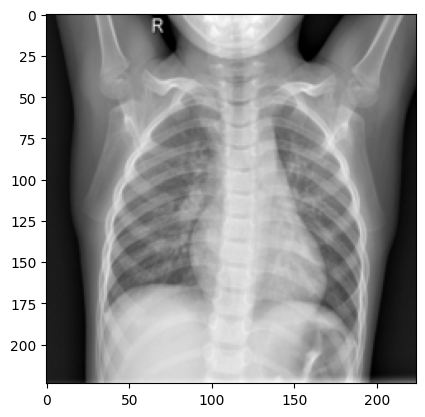

In [4]:
image, label = train_data[0]
print("Image Shape : ", image.shape)
plt.imshow(image.squeeze(), cmap="grey")
plt.show()

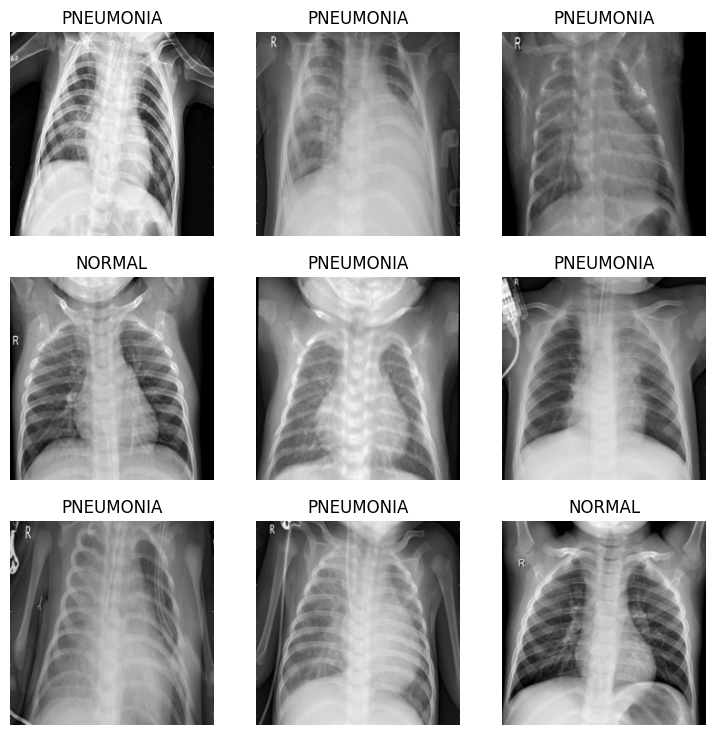

In [5]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, columns = 3,3
count = 1
for i in range(rows):
  for j in range(columns):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, columns, count)
    plt.imshow(img.squeeze(), cmap="grey")
    plt.title(train_data.classes[label])
    plt.axis(False)
    count=count+1
     

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [29]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)
train_dataloader

In [30]:
class_names = train_data.classes
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape, class_names

(torch.Size([32, 3, 224, 224]), torch.Size([32]), ['NORMAL', 'PNEUMONIA'])

In [9]:
class CNN_4Layer_Model(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()
    self.layer_stack1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32,
                  kernel_size=3, stride=1, padding=1),
        nn.ReLU() ##224, 224
    )
    self.layer_stack2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=32,
                  kernel_size=3, stride=1, padding=1),
        nn.ReLU(),  #224, 224
        nn.MaxPool2d(kernel_size=2, stride=2) #112, 112
    )
    self.layer_stack3 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=32,
                  kernel_size=3, stride=1, padding=1),
        nn.ReLU()  #112, 112
    )
    self.layer_stack4 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=32,
                  kernel_size=3, stride=1, padding=1),
        nn.ReLU(), #112, 112
        nn.MaxPool2d(kernel_size=2, stride=2) #56, 56
    )
    self.final_stack = nn.Sequential(
        nn.Flatten(), #56*56
        nn.Linear(in_features=56*56*32, out_features = output_shape) #
    )
  def forward(self,x):
    x = self.layer_stack1(x)
    x = self.layer_stack2(x)
    x = self.layer_stack3(x)
    x = self.layer_stack4(x)
    x = self.final_stack(x)
    return x

model_CNN_4layer = CNN_4Layer_Model(1, 2)
model_CNN_4layer

CNN_4Layer_Model(
  (layer_stack1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer_stack2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_stack3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer_stack4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (final_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=2, bias=True)
  )
)

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params = model_CNN_4layer.parameters(),
                      lr = 0.1)

In [7]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
  train_loss=0
  train_acc=0
  model.to(device)
  for batch, (X, y) in enumerate(data_loader):
    X,y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
  # mlflow.log_param('train loss', train_loss)
  # mlflow.log_param('train accuracy', train_acc)

def test_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
  test_loss=0
  test_acc=0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      X,y = X.to(device), y.to(device)

      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
    # mlflow.log_param('test loss', test_loss)
    # mlflow.log_param('test accuracy', test_acc)

def validation_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
  val_loss=0
  val_acc=0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      X,y = X.to(device), y.to(device)

      val_pred = model(X)

      val_loss += loss_fn(val_pred, y)
      val_acc += accuracy_fn(y_true = y, y_pred = val_pred.argmax(dim=1))

    val_loss /= len(data_loader)
    val_acc /= len(data_loader)
    print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")
    # mlflow.log_param('validation loss', val_loss)
    # mlflow.log_param('validation accuracy', val_acc)

In [9]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [13]:
torch.manual_seed(42)
from tqdm.auto import tqdm
from helper_functions import accuracy_fn
# Measure time
from timeit import default_timer as timer
train_time_start_model = timer()

# Train and test model
epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_CNN_4layer,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    validation_step(data_loader=validation_dataloader,
        model=model_CNN_4layer,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,optimizer = optimizer
    )
    test_step(data_loader=test_dataloader,
        model=model_CNN_4layer,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,optimizer = optimizer
    )

train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model,
                                           end=train_time_end_model,
                                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.58267 | Train accuracy: 74.02%
Validation loss: 0.81353 | Validation accuracy: 50.00%

Test loss: 0.68995 | Test accuracy: 62.34%

Epoch: 1
---------
Train loss: 0.57037 | Train accuracy: 74.29%
Validation loss: 0.82197 | Validation accuracy: 50.00%

Test loss: 0.68909 | Test accuracy: 62.81%

Epoch: 2
---------
Train loss: 0.57040 | Train accuracy: 74.29%
Validation loss: 0.84262 | Validation accuracy: 50.00%

Test loss: 0.70250 | Test accuracy: 62.50%

Epoch: 3
---------
Train loss: 0.57024 | Train accuracy: 74.29%
Validation loss: 0.80896 | Validation accuracy: 50.00%

Test loss: 0.68784 | Test accuracy: 62.34%

Epoch: 4
---------
Train loss: 0.57032 | Train accuracy: 74.29%
Validation loss: 0.81563 | Validation accuracy: 50.00%

Test loss: 0.68778 | Test accuracy: 62.66%

Epoch: 5
---------
Train loss: 0.57041 | Train accuracy: 74.29%
Validation loss: 0.83330 | Validation accuracy: 50.00%

Test loss: 0.69105 | Test accuracy: 63.12%

Epoch: 6
-------

In [9]:
from torchvision.models import vgg16, VGG16_Weights
weights = VGG16_Weights.DEFAULT
weights

VGG16_Weights.IMAGENET1K_V1

In [10]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [12]:
train_data = ImageFolder("chest_xray/train", transform = auto_transforms)
test_data = ImageFolder("chest_xray/test", transform = auto_transforms)
validation_data = ImageFolder("chest_xray/val", transform = auto_transforms)
image, label = train_data[0]
print(image.shape, label)
print(image)

torch.Size([3, 224, 224]) 0
tensor([[[-0.3369, -0.3198, -0.2684,  ..., -0.2513, -0.0972,  0.2967],
         [-0.3369, -0.3027, -0.2856,  ..., -0.2171,  0.1254,  0.5707],
         [-0.3541, -0.3027, -0.2856,  ..., -0.0629,  0.3481,  0.8447],
         ...,
         [-1.0562, -0.9705, -0.8507,  ..., -1.9809, -2.0665, -2.0323],
         [-1.0390, -0.9534, -0.8507,  ..., -2.0323, -2.0665, -2.0323],
         [-1.0390, -0.9534, -0.8335,  ..., -2.0494, -2.0494, -2.0323]],

        [[-0.2150, -0.1975, -0.1450,  ..., -0.1275,  0.0301,  0.4328],
         [-0.2150, -0.1800, -0.1625,  ..., -0.0924,  0.2577,  0.7129],
         [-0.2325, -0.1800, -0.1625,  ...,  0.0651,  0.4853,  0.9930],
         ...,
         [-0.9503, -0.8627, -0.7402,  ..., -1.8957, -1.9832, -1.9482],
         [-0.9328, -0.8452, -0.7402,  ..., -1.9482, -1.9832, -1.9482],
         [-0.9328, -0.8452, -0.7227,  ..., -1.9657, -1.9657, -1.9482]],

        [[ 0.0082,  0.0256,  0.0779,  ...,  0.0953,  0.2522,  0.6531],
         [ 0.0082

In [13]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)
train_dataloader

In [16]:
model = vgg16(weights=weights)
summary(model=model,
        input_size=(32,3, 224, 224),
        col_names=['input_size','output_size'],
        col_width=20,
        row_settings=['var_names']
        )

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/anant/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:46<00:00, 11.9MB/s] 


Layer (type (var_name))                  Input Shape          Output Shape
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]
│    └─ReLU (6)                          [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─Conv2d (7)                        [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─ReLU (8)                          [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─MaxPool2d (9)                     

In [17]:
for param in model.features.parameters():
  param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=25088,
              out_features=2,
              bias=True)
)

In [18]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=['input_size','output_size'],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                  Input Shape          Output Shape
VGG (VGG)                                [32, 3, 224, 224]    [32, 2]
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]
│    └─ReLU (6)                          [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─Conv2d (7)                        [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─ReLU (8)                          [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─MaxPool2d (9)                     [32

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params = model.parameters(),
                      lr = 0.1)

In [33]:
torch.manual_seed(42)
from tqdm.auto import tqdm
from helper_functions import accuracy_fn
# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()
# mlflow.pytorch.log_model(model, 'VGG16')
# Train and test model
mlflow.autolog()
epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    validation_step(data_loader=validation_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,optimizer = optimizer
    )
    test_step(data_loader=validation_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,optimizer = optimizer
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.44452 | Train accuracy: 98.62%
Validation loss: 0.23519 | Validation accuracy: 93.75%

Test loss: 0.23519 | Test accuracy: 93.75%

Epoch: 1
---------
Train loss: 0.10118 | Train accuracy: 99.27%
Validation loss: 2.57455 | Validation accuracy: 93.75%

Test loss: 2.57455 | Test accuracy: 93.75%

Epoch: 2
---------
Train loss: 0.13439 | Train accuracy: 98.98%
Validation loss: 2.92279 | Validation accuracy: 87.50%

Test loss: 2.92279 | Test accuracy: 87.50%

Epoch: 3
---------
Train loss: 0.05727 | Train accuracy: 99.58%
Validation loss: 8.70675 | Validation accuracy: 81.25%

Test loss: 8.70675 | Test accuracy: 81.25%

Epoch: 4
---------
Train loss: 0.02271 | Train accuracy: 99.67%
Validation loss: 7.20066 | Validation accuracy: 81.25%

Test loss: 7.20066 | Test accuracy: 81.25%

Epoch: 5
---------
Train loss: 0.03372 | Train accuracy: 99.75%
Validation loss: 13.56795 | Validation accuracy: 68.75%

Test loss: 13.56795 | Test accuracy: 68.75%

Epoch: 6
-----

In [34]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [35]:
image, label = train_data[0]
print(image.shape, label)
print(image)

torch.Size([3, 224, 224]) 0
tensor([[[-0.3369, -0.3198, -0.2684,  ..., -0.2513, -0.0972,  0.2967],
         [-0.3369, -0.3027, -0.2856,  ..., -0.2171,  0.1254,  0.5707],
         [-0.3541, -0.3027, -0.2856,  ..., -0.0629,  0.3481,  0.8447],
         ...,
         [-1.0562, -0.9705, -0.8507,  ..., -1.9809, -2.0665, -2.0323],
         [-1.0390, -0.9534, -0.8507,  ..., -2.0323, -2.0665, -2.0323],
         [-1.0390, -0.9534, -0.8335,  ..., -2.0494, -2.0494, -2.0323]],

        [[-0.2150, -0.1975, -0.1450,  ..., -0.1275,  0.0301,  0.4328],
         [-0.2150, -0.1800, -0.1625,  ..., -0.0924,  0.2577,  0.7129],
         [-0.2325, -0.1800, -0.1625,  ...,  0.0651,  0.4853,  0.9930],
         ...,
         [-0.9503, -0.8627, -0.7402,  ..., -1.8957, -1.9832, -1.9482],
         [-0.9328, -0.8452, -0.7402,  ..., -1.9482, -1.9832, -1.9482],
         [-0.9328, -0.8452, -0.7227,  ..., -1.9657, -1.9657, -1.9482]],

        [[ 0.0082,  0.0256,  0.0779,  ...,  0.0953,  0.2522,  0.6531],
         [ 0.0082

In [54]:
torch.save(model, 'vgg16.pt')

In [52]:
from PIL import Image
import torchvision.transforms as transforms

img = Image.open('chest_xray/test/NORMAL/NORMAL2-IM-0145-0001.jpeg')
# mean = [0.485, 0.456, 0.406] 
# std = [0.229, 0.224, 0.225]
# transform_norm = transforms.Compose([transforms.ToTensor(), 
# transforms.Resize((224,224)),transforms.Normalize(mean, std)])
# # get normalized image
# img_normalized = transform_norm(img).float()
# img_normalized = img_normalized.unsqueeze_(0)

image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0], std=[1])
])
# input = Variable(image_tensor)
img = image_transform(img).to(device)
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 224, 224])

In [53]:
model(img)

tensor([[-28.8434,  29.0502]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [8]:
class CNN_4Layer_Model(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()
    self.layer_stack1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32,
                  kernel_size=3, stride=1, padding=1),
        nn.ReLU() ##224, 224
    )
    # self.layer_stack2 = nn.Sequential(
    #     nn.Conv2d(in_channels=32, out_channels=32,
    #               kernel_size=3, stride=1, padding=1),
    #     nn.ReLU(),  #224, 224
    #     nn.MaxPool2d(kernel_size=2, stride=2) #112, 112
    # )
    # self.layer_stack3 = nn.Sequential(
    #     nn.Conv2d(in_channels=32, out_channels=32,
    #               kernel_size=3, stride=1, padding=1),
    #     nn.ReLU()  #112, 112
    # )
    # self.layer_stack4 = nn.Sequential(
    #     nn.Conv2d(in_channels=32, out_channels=32,
    #               kernel_size=3, stride=1, padding=1),
    #     nn.ReLU(), #112, 112
    #     nn.MaxPool2d(kernel_size=2, stride=2) #56, 56
    # )
    self.final_stack = nn.Sequential(
        nn.Flatten(), #224*224
        nn.Linear(in_features=224*224*32, out_features = output_shape) #
    )
  def forward(self,x):
    x = self.layer_stack1(x)
    # x = self.layer_stack2(x)
    # x = self.layer_stack3(x)
    # x = self.layer_stack4(x)
    x = self.final_stack(x)
    return x

model_CNN_4layer = CNN_4Layer_Model(1, 2)
model_CNN_4layer

CNN_4Layer_Model(
  (layer_stack1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (final_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1605632, out_features=2, bias=True)
  )
)

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params = model_CNN_4layer.parameters(),
                      lr = 0.1)

In [13]:
torch.manual_seed(42)
from tqdm.auto import tqdm
from helper_functions import accuracy_fn
# Measure time
from timeit import default_timer as timer
train_time_start_model = timer()

# Train and test model
epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_CNN_4layer,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    validation_step(data_loader=validation_dataloader,
        model=model_CNN_4layer,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,optimizer = optimizer
    )
    test_step(data_loader=test_dataloader,
        model=model_CNN_4layer,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,optimizer = optimizer
    )

train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model,
                                           end=train_time_end_model,
                                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 6.80513 | Train accuracy: 73.60%
Validation loss: 0.81259 | Validation accuracy: 50.00%

Test loss: 0.68904 | Test accuracy: 62.34%

Epoch: 1
---------
Train loss: 0.56264 | Train accuracy: 74.52%
Validation loss: 0.83542 | Validation accuracy: 50.00%

Test loss: 0.69521 | Test accuracy: 62.81%

Epoch: 2
---------
Train loss: 0.56285 | Train accuracy: 74.23%
Validation loss: 0.86475 | Validation accuracy: 50.00%

Test loss: 0.69154 | Test accuracy: 62.50%

Epoch: 3
---------
Train loss: 0.53479 | Train accuracy: 75.56%
Validation loss: 0.78564 | Validation accuracy: 50.00%

Test loss: 0.66714 | Test accuracy: 65.16%

Epoch: 4
---------
Train loss: 0.48687 | Train accuracy: 78.99%
Validation loss: 0.83165 | Validation accuracy: 50.00%

Test loss: 0.69432 | Test accuracy: 62.66%

Epoch: 5
---------
Train loss: 0.42233 | Train accuracy: 80.60%
Validation loss: 0.71477 | Validation accuracy: 56.25%

Test loss: 0.69391 | Test accuracy: 68.44%

Epoch: 6
-------

In [ ]:
torch.manual_seed(42)
from tqdm.auto import tqdm
from helper_functions import accuracy_fn
# Measure time
from timeit import default_timer as timer
train_time_start_model = timer()

# Train and test model
epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_CNN_4layer,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    validation_step(data_loader=validation_dataloader,
        model=model_CNN_4layer,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,optimizer = optimizer
    )
    test_step(data_loader=test_dataloader,
        model=model_CNN_4layer,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,optimizer = optimizer
    )

train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model,
                                           end=train_time_end_model,
                                           device=device)

In [14]:
summary(model=model_CNN_4layer,
        input_size=(32, 1, 224, 224),
        col_names=['input_size','output_size'],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                  Input Shape          Output Shape
CNN_4Layer_Model (CNN_4Layer_Model)      [32, 1, 224, 224]    [32, 2]
├─Sequential (layer_stack1)              [32, 1, 224, 224]    [32, 32, 224, 224]
│    └─Conv2d (0)                        [32, 1, 224, 224]    [32, 32, 224, 224]
│    └─ReLU (1)                          [32, 32, 224, 224]   [32, 32, 224, 224]
├─Sequential (final_stack)               [32, 32, 224, 224]   [32, 2]
│    └─Flatten (0)                       [32, 32, 224, 224]   [32, 1605632]
│    └─Linear (1)                        [32, 1605632]        [32, 2]
Total params: 3,211,586
Trainable params: 3,211,586
Non-trainable params: 0
Total mult-adds (M): 616.56
Input size (MB): 6.42
Forward/backward pass size (MB): 411.04
Params size (MB): 12.85
Estimated Total Size (MB): 430.31

In [4]:
from transformers import AutoImageProcessor, ViTForImageClassification, ViTModel, ViTFeatureExtractor

In [3]:
device = 'cpu'

In [11]:
class ImageClassifier(nn.Module):
    def __init__(self, num_labels, encoder):
        super(ImageClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size, 500),
            nn.ReLU(),
            nn.Linear(500, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, num_labels),
            nn.Sigmoid()
        )

    def forward(self, input_values):
        outputs = self.encoder(pixel_values = input_values)
        pooled_output = outputs['last_hidden_state'][:, 0, :]
        logits = self.classifier(pooled_output)
        return logits

In [20]:
model_checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = ViTFeatureExtractor.from_pretrained(model_checkpoint)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
num_labels = 2
encoder = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
model_Vit = ImageClassifier(num_labels, encoder).to(device)
loss_fn = nn.CrossEntropyLoss()

/home/anant/anaconda3/envs/xrayclf/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [21]:
# optimizer = optim.SGD(params = model_Vit.parameters(),
#                       lr = 0.1)
optimizer = optim.SGD(model_Vit.parameters(), lr=0.0001)  #, betas=(0.9, 0.999), eps=1e-08)

In [23]:
summary(model=model_Vit,
        input_size=(32, 3, 224, 224),
        col_names=['input_size','output_size'],
        col_width=20,
        row_settings=['var_names']
        )

# model_Vit.

Layer (type (var_name))                                                Input Shape          Output Shape
ImageClassifier (ImageClassifier)                                      [32, 3, 224, 224]    [32, 2]
├─ViTModel (encoder)                                                   --                   [32, 768]
│    └─ViTEmbeddings (embeddings)                                      [32, 3, 224, 224]    [32, 197, 768]
│    │    └─ViTPatchEmbeddings (patch_embeddings)                      [32, 3, 224, 224]    [32, 196, 768]
│    │    └─Dropout (dropout)                                          [32, 197, 768]       [32, 197, 768]
│    └─ViTEncoder (encoder)                                            [32, 197, 768]       [32, 197, 768]
│    │    └─ModuleList (layer)                                         --                   --
│    └─LayerNorm (layernorm)                                           [32, 197, 768]       [32, 197, 768]
│    └─ViTPooler (pooler)                                      

In [24]:
for param in model_Vit.encoder.parameters():
  param.requires_grad = False

# model_vit
# model_Vit

summary(model=model_Vit,
        input_size=(32, 3, 224, 224),
        col_names=['input_size','output_size'],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                                                Input Shape          Output Shape
ImageClassifier (ImageClassifier)                                      [32, 3, 224, 224]    [32, 2]
├─ViTModel (encoder)                                                   --                   [32, 768]
│    └─ViTEmbeddings (embeddings)                                      [32, 3, 224, 224]    [32, 197, 768]
│    │    └─ViTPatchEmbeddings (patch_embeddings)                      [32, 3, 224, 224]    [32, 196, 768]
│    │    └─Dropout (dropout)                                          [32, 197, 768]       [32, 197, 768]
│    └─ViTEncoder (encoder)                                            [32, 197, 768]       [32, 197, 768]
│    │    └─ModuleList (layer)                                         --                   --
│    └─LayerNorm (layernorm)                                           [32, 197, 768]       [32, 197, 768]
│    └─ViTPooler (pooler)                                      

In [31]:
torch.manual_seed(42)
from tqdm.auto import tqdm
from helper_functions import accuracy_fn
# Measure time
from timeit import default_timer as timer
train_time_start_model = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loss=0
    train_acc=0
    model_Vit.to(device)
    for batch, (X, y) in enumerate(test_dataloader):
        X,y = X.to(device), y.to(device)
        y_pred = model_Vit(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(test_dataloader)
    train_acc /= len(test_dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.69260 | Train accuracy: 62.34%
Epoch: 1
---------
Train loss: 0.69259 | Train accuracy: 62.50%
Epoch: 2
---------


KeyboardInterrupt: 

In [3]:
from torchvision.models import resnet50, ResNet50_Weights
resnet_weights = ResNet50_Weights.DEFAULT
resnet_weights

ResNet50_Weights.IMAGENET1K_V2

In [4]:
resnet_transform = resnet_weights.transforms()
resnet_transform

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [5]:
train_data_resnet = ImageFolder("chest_xray/train", transform = resnet_transform)
test_data_resnet = ImageFolder("chest_xray/test", transform = resnet_transform)
validation_data_resnet = ImageFolder("chest_xray/val", transform = resnet_transform)
image, label = train_data_resnet[0]
print(image.shape, label)
print(image)

torch.Size([3, 224, 224]) 0
tensor([[[-0.6109, -0.5767, -0.5596,  ...,  0.7248,  0.4851,  0.3138],
         [-0.6281, -0.5767, -0.5938,  ...,  0.5878,  0.3823,  0.2624],
         [-0.6452, -0.5938, -0.5938,  ...,  0.4679,  0.3138,  0.2111],
         ...,
         [-1.8097, -1.8268, -1.8439,  ..., -1.9124, -1.8953, -1.8610],
         [-1.8097, -1.8268, -1.8268,  ..., -1.8782, -1.8610, -1.8439],
         [-1.8097, -1.8097, -1.8439,  ..., -1.7583, -1.7412, -1.7240]],

        [[-0.4951, -0.4601, -0.4426,  ...,  0.8704,  0.6254,  0.4503],
         [-0.5126, -0.4601, -0.4776,  ...,  0.7304,  0.5203,  0.3978],
         [-0.5301, -0.4776, -0.4776,  ...,  0.6078,  0.4503,  0.3452],
         ...,
         [-1.7206, -1.7381, -1.7556,  ..., -1.8256, -1.8081, -1.7731],
         [-1.7206, -1.7381, -1.7381,  ..., -1.7906, -1.7731, -1.7556],
         [-1.7206, -1.7206, -1.7556,  ..., -1.6681, -1.6506, -1.6331]],

        [[-0.2707, -0.2358, -0.2184,  ...,  1.0888,  0.8448,  0.6705],
         [-0.2881

In [6]:
train_dataloader_resnet = DataLoader(train_data_resnet, batch_size=32, shuffle=True)
validation_dataloader_resnet = DataLoader(validation_data_resnet, batch_size=32, shuffle=True)
test_dataloader_resnet = DataLoader(test_data_resnet, batch_size=32, shuffle=True)
train_dataloader_resnet

In [7]:
resnet_model = resnet50(weights=resnet_weights)

for param in resnet_model.parameters():
    param.requires_grad = False

resnet_model.fc = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=2048,
              out_features=2,
              bias=True)
)

summary(model=resnet_model,
        input_size=(32,3, 224, 224),
        col_names=['input_size','output_size'],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                  Input Shape          Output Shape
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 2]
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]
│    │    └─BatchNorm2d (bn1)            [32, 64, 56, 56]     [32, 64, 56, 56]
│    │    └─ReLU (relu)                  [32, 64, 56, 56]     [32, 64, 56, 56]
│    │    └─Conv2d (conv2)               [32, 64, 56, 56]     [32, 64, 56, 56]
│    │    └─BatchNorm2d (bn2)            [32, 64, 56, 56]

In [8]:
resnet_loss_fn = nn.CrossEntropyLoss()
resnet_optimizer = optim.RMSprop(params = resnet_model.parameters(),
                      lr = 0.1)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [11]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("new")  # Replace with your experiment name
# Start training loop
epochs = 5

with mlflow.start_run(run_name="RESNET50 model"):
    for epoch in tqdm(range(epochs)):
        mlflow.log_metric("epoch", epoch)
        print(f"Epoch: {epoch+1}\n---------")

        #Training Loop
        train_loss = 0
        train_acc = 0
        resnet_model.to(device)

        for batch, (X, y) in enumerate(train_dataloader_resnet):
            X, y = X.to(device), y.to(device)
            y_pred = resnet_model(X)
            loss = resnet_loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            resnet_optimizer.zero_grad()
            loss.backward()
            resnet_optimizer.step()

        train_loss /= len(train_dataloader_resnet)
        train_acc /= len(train_dataloader_resnet)
        
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        # mlflow.log_param("epoch", epoch + 1)

        val_loss = 0
        val_acc = 0
        resnet_model.eval()

        with torch.inference_mode():
            for X, y in validation_dataloader_resnet:
                X, y = X.to(device), y.to(device)
                val_pred = resnet_model(X)
                val_loss += resnet_loss_fn(val_pred, y).item()
                val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))

            val_loss /= len(validation_dataloader_resnet)
            val_acc /= len(validation_dataloader_resnet)

            print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)

        test_loss = 0
        test_acc = 0
        resnet_model.eval()

        with torch.inference_mode():
            for X, y in test_dataloader_resnet:
                X, y = X.to(device), y.to(device)
                test_pred = resnet_model(X)
                test_loss += resnet_loss_fn(test_pred, y).item()
                test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

            test_loss /= len(test_dataloader_resnet)
            test_acc /= len(test_dataloader_resnet)

            print(f"test loss: {test_loss:.5f} | test accuracy: {test_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("test_loss", test_loss, step=epoch)
        mlflow.log_metric("test accuracy", test_acc, step=epoch)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
---------
Train loss: 1.89271 | Train accuracy: 93.23%
Validation loss: 2.69313 | Validation accuracy: 68.75%

test loss: 6.02462 | test accuracy: 85.00%

Epoch: 2
---------
Train loss: 1.16137 | Train accuracy: 94.96%
Validation loss: 4.71052 | Validation accuracy: 75.00%

test loss: 7.32264 | test accuracy: 84.06%

Epoch: 3
---------
Train loss: 0.98151 | Train accuracy: 96.13%
Validation loss: 5.09706 | Validation accuracy: 62.50%

test loss: 8.93881 | test accuracy: 83.44%

Epoch: 4
---------
Train loss: 0.72359 | Train accuracy: 96.80%
Validation loss: 1.40470 | Validation accuracy: 93.75%

test loss: 7.63452 | test accuracy: 84.69%

Epoch: 5
---------
Train loss: 0.64914 | Train accuracy: 96.78%
Validation loss: 3.07083 | Validation accuracy: 81.25%

test loss: 7.27209 | test accuracy: 85.62%



In [15]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
from torchvision.models import VGG16_Weights, vgg16
vgg16_weights = VGG16_Weights.DEFAULT
vgg16_weights

VGG16_Weights.IMAGENET1K_V1

In [4]:
vgg16_transform = vgg16_weights.transforms()
vgg16_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [5]:
train_data_vgg16 = ImageFolder("chest_xray/train", transform = vgg16_transform)
test_data_vgg16 = ImageFolder("chest_xray/test", transform = vgg16_transform)
validation_data_vgg16 = ImageFolder("chest_xray/val", transform = vgg16_transform)
train_dataloader_vgg16 = DataLoader(train_data_vgg16, batch_size=32, shuffle=True)
validation_dataloader_vgg16 = DataLoader(validation_data_vgg16, batch_size=32, shuffle=True)
test_dataloader_vgg16 = DataLoader(test_data_vgg16, batch_size=32, shuffle=True)
train_dataloader_vgg16

In [6]:
vgg16_model = vgg16(weights=vgg16_weights)
vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
vgg16_model = vgg16(weights=vgg16_weights)
vgg16_model
for param in vgg16_model.parameters():
    param.requires_grad = False

vgg16_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=25088,
              out_features=2,
              bias=True)
)

summary(model=vgg16_model,
        input_size=(32,3, 224, 224),
        col_names=['input_size','output_size'],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                  Input Shape          Output Shape
VGG (VGG)                                [32, 3, 224, 224]    [32, 2]
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]
│    └─ReLU (6)                          [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─Conv2d (7)                        [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─ReLU (8)                          [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─MaxPool2d (9)                     [32

In [9]:
import torch.optim.lr_scheduler as lr_scheduler

def polynomial_decay_schedule(x):
    return 0.1 * ((1 - (x / 31)) ** 2)

In [10]:
device = 'cuda'
vgg16_loss_fn = nn.CrossEntropyLoss()
vgg16_optimizer = optim.RMSprop(params = vgg16_model.parameters(),
                      lr = 0.1)

scheduler = lr_scheduler.LambdaLR(vgg16_optimizer, polynomial_decay_schedule)

epochs = 5

for epoch in tqdm(range(1, epochs + 1)):
    print(f"Epoch: {epoch}\n---------")

    # Training Loop
    train_loss = 0
    train_acc = 0
    vgg16_model.to(device)

    for batch, (X, y) in enumerate(train_dataloader_vgg16):
        X, y = X.to(device), y.to(device)
        y_pred = vgg16_model(X)
        loss = vgg16_loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        vgg16_optimizer.zero_grad()
        loss.backward()
        vgg16_optimizer.step()

    before_lr = vgg16_optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = vgg16_optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))
    train_loss /= len(train_dataloader_vgg16)
    train_acc /= len(train_dataloader_vgg16)

    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

    val_loss = 0
    val_acc = 0
    vgg16_model.eval()

    with torch.inference_mode():
        for X, y in validation_dataloader_vgg16:
            X, y = X.to(device), y.to(device)
            val_pred = vgg16_model(X)
            val_loss += vgg16_loss_fn(val_pred, y).item()
            val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))

        val_loss /= len(validation_dataloader_vgg16)
        val_acc /= len(validation_dataloader_vgg16)

        print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

    test_loss = 0
    test_acc = 0
    vgg16_model.eval()

    with torch.inference_mode():
        for X, y in test_dataloader_vgg16:
            X, y = X.to(device), y.to(device)
            test_pred = vgg16_model(X)
            test_loss += vgg16_loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(test_dataloader_vgg16)
        test_acc /= len(test_dataloader_vgg16)

        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
---------
Epoch 1: SGD lr 0.0100 -> 0.0094
Train loss: 4.05489 | Train accuracy: 94.67%
Validation loss: 6.50120 | Validation accuracy: 87.50%

Test loss: 20.49183 | Test accuracy: 80.94%

Epoch: 2
---------
Epoch 2: SGD lr 0.0094 -> 0.0088
Train loss: 0.72929 | Train accuracy: 98.04%
Validation loss: 0.16557 | Validation accuracy: 93.75%

Test loss: 13.10629 | Test accuracy: 83.75%

Epoch: 3
---------
Epoch 3: SGD lr 0.0088 -> 0.0082
Train loss: 0.46298 | Train accuracy: 98.49%
Validation loss: 19.89754 | Validation accuracy: 68.75%

Test loss: 40.21290 | Test accuracy: 70.78%

Epoch: 4
---------
Epoch 4: SGD lr 0.0082 -> 0.0076
Train loss: 0.49093 | Train accuracy: 98.85%
Validation loss: 7.13923 | Validation accuracy: 87.50%

Test loss: 23.38711 | Test accuracy: 79.53%

Epoch: 5
---------
Epoch 5: SGD lr 0.0076 -> 0.0070
Train loss: 0.19806 | Train accuracy: 99.25%
Validation loss: 3.89884 | Validation accuracy: 87.50%

Test loss: 27.03931 | Test accuracy: 81.25%



In [11]:
torch.save(vgg16_model, 'vgg16_trial.pt')